<a href="https://colab.research.google.com/github/iisuslik43/nlp/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pymorphy2
! pip install transformers

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 7.1MB 8.0MB/s 
     |████████████████████████████████| 317kB 2.7MB/s 
     |████████████████████████████████| 645kB 50.6MB/s 
     |████████████████████████████████| 1.0MB 48.5MB/s 
     |████████████████████████████████| 860kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=758e743f4ec1738d5430874300f0592473e3f4fc7e2e9da7c9cbf9ba4bf7ef8b
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
def draw_losses(train_losses, test_losses):
    plt.plot(list(range(len(train_losses))), train_losses, color='r', label='train')
    plt.plot(list(range(len(test_losses))), test_losses, color='b', label='test')
    plt.legend()
    plt.show()

In [0]:
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import pickle
import torch.nn.functional as F
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! cp -r "drive/My Drive/nlp" .

In [0]:
files = {}
for file in os.listdir("nlp/Collection3"):
  files[file] = open("nlp/Collection3/" + file).read()

In [0]:
to_delete = set()
for filename, content in files.items():
  name, ext = filename.split('.')
  opposite = 'ann' if ext == 'txt' else 'txt'
  if (name + '.' + opposite) not in files:
    to_delete.add(filename)
for name in to_delete:
  del files[name]

In [0]:
with_labels = {}
for filename, content in files.items():
  name, ext = filename.split('.')
  if name in with_labels:
    continue
  opposite = 'ann' if ext == 'txt' else 'txt'
  opposite_name = name + '.' + opposite
  if opposite == 'ann':
    opposite_name, filename = filename, opposite_name
  with_labels[name] = (files[opposite_name], files[filename])

In [0]:
def reformat_label(label_info):
  num, label, first, last = label_info.split()[:4]
  return (label, int(first), int(last))
with_labels = {filename: (content.replace('\n', '\\n'), list(map(reformat_label, labels[:-1].split('\n'))))
               for filename, (content, labels) in with_labels.items()}


In [7]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    do_lower_case=False
)
bert = BertModel.from_pretrained('bert-base-multilingual-cased')

In [0]:
import re
from itertools import groupby
ORG = 2
PERSON = 1
NONE = 0
tag_map = {'LOC': NONE, 'ORG': ORG, 'PER': PERSON}
def to_dataset(with_labels, tokenizer):
  data = []
  tags = []
  for filename, (content, labels) in tqdm(with_labels.items()):
    mask = [0] * len(content)
    for tag, first, last in labels:
      mask_tag = tag_map[tag]
      for i in range(first, last):
        mask[i] = mask_tag
    both = ''
    for i in range(len(content)):
      both += content[i]
      both += str(mask[i])
    sentences = [s for s in re.split(r'(\\0n0)+', both) if s != '' and s != '\\0n0']
    tokens_res = []
    for b in sentences:
      prev_tag = '3'
      prev_text = ''
      tokens = []
      for i in range(len(b) // 2):
        c = b[2 * i]
        tag = b[2 * i + 1]
        if tag != prev_tag:
          if prev_text != '':
            tokens.append((prev_text, prev_tag))
          prev_tag = tag
          prev_text = ''
        prev_text += c
      
      if prev_text != '':
        tokens.append((prev_text, prev_tag))
      tokens_res.append(tokens)
    for sentences in tokens_res:
      sentence_data, sentence_tags = [], []
      for sub_classes, tag in sentences:
        tokenized = tokenizer.tokenize(sub_classes)
        sentence_data += tokenized
        sentence_tags += [int(tag)] * len(tokenized)
      data.append(sentence_data)
      tags.append(sentence_tags)
  return data, tags

In [32]:
data1, tags1 = to_dataset(with_labels, tokenizer)

In [0]:
def add_padding(data, tags, tokenizer, max_len=None):
  masks = []
  if max_len is None:
    max_len = max([len(d) for d in data])
  new_data = []
  mask = []
  all_data = []
  for sent, sent_tags in zip(data, tags):
    pad_len = max_len - len(sent)
    mask.append([1] * len(sent) + [0] * pad_len)
    sent_tags += [0] * pad_len
    sent += [tokenizer.pad_token] * pad_len
    new_data.append(tokenizer.convert_tokens_to_ids(sent))
  return new_data, tags, mask

In [0]:
data, tags, mask = add_padding(data1, tags1, tokenizer)

In [0]:
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')

        for param in self.bert.parameters():
            param.requires_grad = False

        layers = [
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 3)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, text, mask):
        x = self.bert(text, attention_mask=mask)[0]
        x = self.layers(x)
        x = x.permute(0, 2, 1)
        return x

In [0]:
class DataSet:
    def __init__(self, data, tags, mask):
        self.data, self.tags, self.mask = torch.tensor(np.array(data)), torch.tensor(np.array(tags)), torch.tensor(np.array(mask))

    def __len__(self):
        return len(self.tags)

    def __getitem__(self, idx):
        return self.data[idx], self.tags[idx], self.mask[idx]

In [0]:
class MaskedCrossEntropyLoss(nn.Module):
    EPS  = 1e-8

    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, output, target, mask):
        x = self.softmax(output)
        x = -torch.log(x + MaskedCrossEntropyLoss.EPS)
        x = torch.gather(x, 1, target[:, None, :])
        x = (x * mask).mean()
        return x

In [50]:
BATCH_SIZE = 70
SPLIT = 6700
train_data_loader = torch.utils.data.DataLoader(
    dataset=DataSet(data[:SPLIT], tags[:SPLIT], mask[:SPLIT]),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_data_loader = torch.utils.data.DataLoader(
    dataset=DataSet(data[SPLIT:], tags[SPLIT:], mask[SPLIT:]),
    batch_size=20,
    shuffle=False
)

TypeError: ignored

In [0]:
model = TextClassifier().to(device)
optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()))
losser = MaskedCrossEntropyLoss()

In [52]:
train_losses = []
test_losses = []
n_epochs = 20
for epoch in tqdm(range(n_epochs)):
    for x, y, mask_b in tqdm(train_data_loader):
        x, y, mask_b = torch.tensor(x).to(device), torch.tensor(y).to(device), torch.tensor(mask_b).to(device)
        optimizer.zero_grad()
        output = model(x, mask_b)
        loss = losser(output, y, mask_b)
        train_loss = loss.item()
        loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss)
        with torch.no_grad():
          test_losses_b = []
          for xt, yt, mask_bt in val_data_loader:
            xt, yt, mask_bt = torch.tensor(xt).to(device), torch.tensor(yt).to(device), torch.tensor(mask_bt).to(device)
            output_t = model(xt, mask_bt)
            test_losses_b.append(losser(output_t, yt, mask_bt).item())
            break
          test_loss = np.mean(test_losses_b)
        test_losses.append(test_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


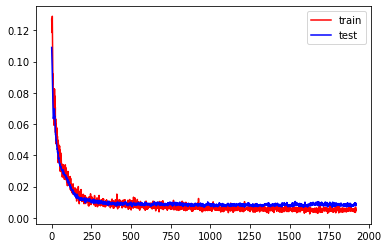

In [53]:
draw_losses(train_losses, test_losses)

In [0]:
with open('dataset_40163_1.txt') as f:
  lines = f.read().split('\n')[:-1]

In [0]:
def izi_tokens(line):
  tokens = []
  indexes = []
  lens = []
  accum = ''
  for i in range(len(line)):
    if line[i] in ' .,!@#$^)(*&:;"\'«»':
      if accum != '':
        tokens.append(accum)
        indexes.append(i - len(accum))
        lens.append(len(accum))
        accum = ''
    else:
      accum += line[i]
  
  if accum != '':
    tokens.append(accum)
    indexes.append(i - len(accum))
    lens.append(len(accum))
  bert_indexes = []
  bert_sentence = []
  for i, token in enumerate(tokens):
    bert_tokens = tokenizer.tokenize(token)
    bert_indexes += [i] * len(bert_tokens)
    bert_sentence += bert_tokens
  return bert_sentence, bert_indexes, indexes, lens, tokens

In [49]:
softmax = nn.Softmax(dim=1)
for line in lines:
  bert_sentence, bert_indexes, indexes, lens, tokens = izi_tokens(line)
  no_pad_len = len(bert_sentence)
  bert_tensor, fake, mask = add_padding([bert_sentence], [[0] * len(bert_sentence)], tokenizer, 506)
  bert_tensor, mask = torch.tensor(bert_tensor).to(device), torch.tensor(mask).to(device)
  with torch.no_grad():
    output = softmax(model(bert_tensor, mask))
  output = output.permute(0, 2, 1)[0].cpu().numpy()
  res_map = {}
  for i in range(no_pad_len):
    probs = output[i]
    real_i = bert_indexes[i]
    res_map[real_i] = res_map.get(real_i, np.zeros(3)) + probs
  res_str = ''
  for i, probs in res_map.items():
    mean_probs = probs / sum(probs)
    res = np.argmax(mean_probs)
    if res != 0:
      tag = 'PERSON' if res == 1 else 'ORG'
      res_str += f'{indexes[i]} {lens[i]} {tag} '
  res_str += 'EOL'
  print(res_str)

EOL
EOL
17 6 ORG 24 12 ORG 71 6 PERSON 78 6 PERSON 97 5 PERSON EOL
20 8 PERSON 29 7 PERSON 38 6 PERSON 45 6 PERSON 53 9 PERSON 63 7 PERSON 72 7 PERSON 80 7 PERSON 89 6 PERSON 96 6 PERSON 104 6 PERSON 111 8 PERSON 121 7 PERSON 129 8 PERSON 139 7 PERSON 147 12 PERSON 161 6 PERSON 168 5 PERSON 176 9 PERSON 186 6 PERSON EOL
EOL
35 4 ORG 42 6 ORG EOL
EOL
EOL
EOL
61 9 ORG 73 6 ORG EOL
2 6 PERSON 9 8 PERSON EOL
26 7 PERSON 34 6 PERSON EOL
EOL
59 7 PERSON 67 9 PERSON EOL
EOL
EOL
EOL
22 9 PERSON EOL
9 7 PERSON 17 4 PERSON 85 7 PERSON 93 5 PERSON EOL
EOL
114 5 PERSON 120 2 PERSON 123 5 PERSON 149 7 PERSON 157 7 PERSON 199 8 PERSON 208 7 PERSON 224 3 ORG 231 7 PERSON 239 8 PERSON 263 15 ORG 283 6 PERSON 290 7 PERSON EOL
EOL
41 5 ORG 47 7 PERSON 57 6 PERSON 64 10 PERSON 76 10 ORG EOL
48 3 ORG 52 4 ORG 59 4 PERSON EOL
14 6 PERSON EOL
39 10 ORG 50 8 ORG EOL
30 5 PERSON EOL
29 11 PERSON 41 9 PERSON EOL
20 9 ORG 38 6 ORG EOL
EOL
EOL
EOL
7 6 PERSON EOL
EOL
EOL
EOL
21 7 PERSON 29 4 PERSON EOL
EOL
EOL
30